**POROUS CARBON CREATOR ALGORITHM**

><span style="color:brown">`Associated Publication:` <br> Atomistic-to-Continuum Modeling of Carbon Foam: A New Approach to Finite Element Simulation <br>
C. Ugwumadu, W. Downs, R. Thapa, R. Olson III, M. Ali, J. Trembly, Y. Al-Majali and D. A. Drabolda </span>


This script creates porous carbon model with desired porosity and pore distribution, which is then optimized using molecular dynamics simulation


**Authors Information** 

**Name**:: C. Ugwumadu, R. Thapa, and D. A. Drabold

**Affiliation** (at the time of creation):: Ohio University, Athens Ohio, 45701, USA.

**Date** (published Version):: May, 11 2024

**Contact**:: ugwumaduchinonso@gmail.com

><span style="color:red">*This algorithm is freely distributed and can be adapted as the user sees fit, all we ask is that you cite our work.* Thank You!!!</span>

# Dependencies

In [1]:
import random as ran
import numpy as np
from scipy import stats as st
import time
from periodictable import H,C 
import matplotlib.pyplot as plt

# Parameter Initialization

## Parameters to build model bounding box and define the density

> Set the number of atoms (`num_atoms`) and the desired density (`density`), if differnt from the default in the `boxSize` function.

In [2]:
num_atoms = 2000  # Number of Carbon atoms
density =  0.6   # Desired Density of the foam
num_atoms_arr = np.array([num_atoms], dtype = np.int64)

## Parameters to compute Pore distribution from pre-defined porosity

As described in our paper, our method to determine the pore distribution from the pre-defined porosity $\xi_i$ is obtained as:

\begin{equation}
\xi_i = \sum_{n=1}^N \frac{v_n}{V}
\end{equation}

\noindent where $N$, $\nu_n$, and $V$ are the total number of pores, the pore volume sampled from a uniform distribution, and the bounding box volume, respectively.

**Eqn. (1)** has been implemented in the `poreCreator` function below. Check and adjust the (default) parameter arguments accordingly


In [3]:
num_pores = 30
porosity = 0.7
max_pore_size_value = 0.5 # of the box lenght

## Other parameters required for the calculations

> The `cut_off` and `pore_overlap` parameters determine the atom-atom cutoff and the extent of pore overlaps in the model. 
<font color="red"> Note that </font> the `pore_overlap` argument cannot be less than or equal to 0. Lower (higher) values indicate high (low) overlap of the pores.

In [4]:
cut_off = 1.4
pore_overlap = 0.3

> Set the naming convention for the output files

In [5]:
stringDensity = str(density).replace(".","p")+"gcc_"
stringNumAtoms = str(num_atoms)+"atoms_"
stringFoamOverlap = str(pore_overlap).replace(".","p")+"overlap"
stringNoFoam = str(num_pores)+"pores_"

atoms_vasp = "POSCAR_"+stringNumAtoms+stringDensity+stringNoFoam+stringFoamOverlap
pores_vasp = "POSCAR_PORES_"+stringNumAtoms+stringDensity+stringNoFoam+stringFoamOverlap
atoms_and_pores_xyz = "ovito_"+stringNumAtoms+stringDensity+stringNoFoam+stringFoamOverlap+".xyz"

# Functions

><span style = "color:red">We have used *keyword-only arguments* for the functions to ensure the user knows what they are doing </span> :)

In [6]:
def boxSize(*,density=density):
    '''
    This function predicts the box size for the porous carbon model, in units of angstrom
    '''

    atom_mass_amu = np.array([C.mass])
    atom_mass_gram = [atom*1.66054e-24 for atom in atom_mass_amu]  #Convert amu to grams (1 amu = 1.66054e-24 g)

    total_mass = sum([atom_mass_gram[i]*num_atoms_arr[i] for i in range(np.size(atom_mass_gram))])
    volume = total_mass / density

    box_cm = volume**(1/3) #(cm)
    ##convert box lenght  in cm to armstrong
    box_arm = box_cm/1e-8
    print(f"The box lenght is {box_arm:.2f} \u212B")
    return box_arm, volume


def uniformPore(*, max_pore_size=max_pore_size_value):
    '''
    This function obtains a uniform pore distribution
    The max_pore_size paramter can be changed to desired maximum pore size
    '''
    return np.random.rand() * (box*max_pore_size)


def chiPore(*, max_pore_size = max_pore_size_value , df = 1,loc = 0, scale = .25, size=1):
    '''
    This function obtains a chi distributed pore distribution (https://en.wikipedia.org/wiki/Chi_distribution)
    The default parameter aguments are set to resemble a half-Gaussian
    The scale of .25 is set so that the maximum is around 1, to get the max allowed pore sized
    '''
    return st.chi.rvs(df, loc,scale,size) * (box*max_pore_size)


def betaPore(*, max_pore_size=max_pore_size_value , a = 4, b = 4):
    '''
    This function obatins a beta distribution (https://en.wikipedia.org/wiki/Beta_distribution)
    The parameters, a and b, set at 4 give a non-negative bell-shaped distribution, akin to a Gaussian Distribution
    '''
    return np.random.beta(4,4) * (box*max_pore_size)

def poreCreator(*, porosity = porosity, num_pores=num_pores, epsilon=0.1, pore_dist_kind = 3):
    '''
    This function creates the pores in a desired distribution and porosity
    
    porosity is the desired porosity, example; 0.5
    num_pores is the number of pores you want to sample
    epsilon ensures that we select a distribution that is less the desired porosity. We set this to 0.1
    pore_dist_kind specify what pore distribution is preffered example 3 (default) is the beta distribution
    '''

    poreRadii_list = []
    poreVolume_sum = 0
    i = 0           #iterator for our loop
    restarts = 0    #tells how many times this function is restarted when the distribution surpases the desired porsity
    porosity_threshold = porosity - epsilon


    while i < num_pores:
    
        if poreVolume_sum <= porosity_threshold:
            
            if pore_dist_kind == 1:
                name = "Uniform Distribution"
                pore_radius = uniformPores()
                
            elif pore_dist_kind == 2:
                name = "Chi Distribution"
                pore_radius = chiPore()
                
            else:
                name = "Beta Distribution"
                pore_radius = betaPore()
            
            poreVolume_sum += pore_radius**3/box**3
            poreRadii_list.append(pore_radius)
            i += 1
        
              
            if poreVolume_sum > porosity:
                restarts += 1
                print(f"Number of restarts = {restarts}", end = '\r')
                poreVolume_sum = 0
                i = 0
                poreRadii_list = []
            
            
            # Ensure the last pore sums to the desired porosity
            if i == num_pores-1:
                print(f"Sampled up to {i} pores. Current Porosity is: {poreVolume_sum:.2f}")
                last_poreVolume = abs((porosity - poreVolume_sum)) * box**3
                print(f"Added porosity fraction is {(last_poreVolume/box**3):.2f}")
                poreRadii_list.append(last_poreVolume**(1/3))
                poreVolume_sum += last_poreVolume/box**3
                print(f"Added last pore. Final porosity is: {poreVolume_sum:.2f}")
                break
            
   
        if poreVolume_sum > porosity_threshold:
            restarts += 1
            print(f"Number of restarts = {restarts}", end='\r')
            poreVolume_sum = 0
            i = 0
            poreRadii_list = []
        
    print()
    print(f"                 *** Pore Radii List for {len(poreRadii_list)} Pores ***")
    print(np.round(poreRadii_list,2))
    
    return name, poreRadii_list
    

## Function Implementations

In [7]:
box, volume = boxSize(density=density)
distribution_kind, poreRadii_list = poreCreator() # obtain the pore distribution
num_pores = len(poreRadii_list)                   # Ensure that the len of the pore distribution is same as the output

The box lenght is 40.51 Å
Sampled up to 29 pores. Current Porosity is: 0.47
Added porosity fraction is 0.23
Added last pore. Final porosity is: 0.70

                 *** Pore Radii List for 30 Pores ***
[ 6.63 14.53  6.4   9.29  9.2  11.09  4.09 11.98  3.47  5.72 16.76  9.02
 10.56 10.03  6.46  9.47  7.87  7.17  6.09  9.33  7.74 12.51  6.26 11.1
  9.5  11.36  8.28 15.35 12.18 24.64]


### Visualize the Pore Distribution

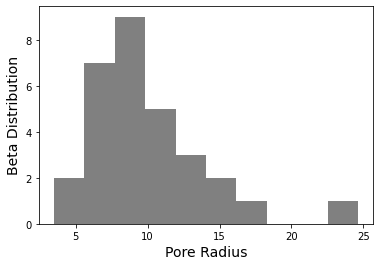

In [8]:
plt.hist(poreRadii_list, color = "gray")
plt.xlabel("Pore Radius", fontsize = 14)
plt.ylabel(distribution_kind, fontsize = 14)
plt.show()

# Main Program

>Here we use the functions and the parameters to create the model. <font color=red> Please note that </font> the algorithm may take a long time (up to days) for very large models on a low-perfomance computer. This code was designed to run in a high-performance computer, as such, not much as been considered for code optimization.

At the end of running this script, 3 files will be created. 

1. A POSCAR (`VASP`) file containing the atoms without the pores
2. A POSCAR file containing the pores without the atoms
3. An extended *.xyz* file containing atoms and pores, for visualization in an atom visualizer like `OVITO`.

<font color=red> Please note that </font> the sizes of the pores in the *.xyz* file has been scaled by half so that they are visually presentable.

In [9]:
start = time.time()

out1 = open(atoms_vasp, 'w')
out2 = open(pores_vasp, 'w')

pos = np.zeros([num_atoms+num_pores,3],float)   ## A list that takes in the position of the atoms and pores

print(f"Number of pores and atoms: {np.shape(pos)[0]} in {np.shape(pos)[1]} dimensions")

################# POSCAR header for the atoms #######################################
print (stringNumAtoms,stringDensity,stringNoFoam,stringFoamOverlap, file = out1)
print ("%16.10f"%(box),  file = out1)
print ( "%23.16f"%(1.0),"%22.16f"%(0.0),"%22.16f"%(0.0),  file = out1)
print ( "%23.16f"%(0.0),"%22.16f"%(1.0),"%22.16f"%(0.0), file = out1)
print ( "%23.16f"%(0.0),"%22.16f"%(0.0),"%22.16f"%(1.0), file = out1)
print ( "   C", file = out1)
print ( "   ",num_atoms, file = out1)
print ("Direct", file = out1)
####################################################################################

################# POSCAR header for the pores #######################################
print ("PORES:"+stringNumAtoms,stringDensity,stringNoFoam,stringFoamOverlap, file = out2)
print ("%16.10f"%(box),  file = out2)
print ( "%23.16f"%(1.0),"%22.16f"%(0.0),"%22.16f"%(0.0),  file = out2)
print ( "%23.16f"%(0.0),"%22.16f"%(1.0),"%22.16f"%(0.0), file = out2)
print ( "%23.16f"%(0.0),"%22.16f"%(0.0),"%22.16f"%(1.0), file = out2)
print ( "   C", file = out2)
print ( "   ",num_pores, file = out2)
print ("Direct", file = out2)
####################################################################################


ct = 0
rnd = lambda i: i-round(i/box)*box  ## This makes rnd a function that takes i and perform i - round(i/box)*box
vec_rnd = np.vectorize(rnd)         ## takes  a function and gives result in a callable vectorised function

print ("Now creating the center of the foams")

while ct < num_pores:

    center =np.array([box*ran.random(),box*ran.random(),box*ran.random()])
    test = 0
    while test < ct:
        pore_distance = center-pos[test][:]
        pore_distance = vec_rnd(pore_distance)

        if sum(map(lambda i: i*i, pore_distance)) < (pore_overlap*poreRadii_list[test])**2:
            center =np.array([box*ran.random(),box*ran.random(),box*ran.random()])
            test = 0
        else:
            
            ### Uncomment for debugging
            #print(f"{sum(map(lambda i: i*i, pore_distance))} > {(pore_overlap*poreRadii_list[ct])**2}")
            ###################################################################################
            
            test +=1 
           
    pos[ct][:] = center[:]
    
    ### Print pore position to file ##############################################################
    print ("%20.16f"%(center[0]/box),"%20.16f"%(center[1]/box),"%20.16f"%(center[2]/box),
           "%20.16f"%(poreRadii_list[ct]) , file = out2)
    
    ct += 1
    print (f"Placing center for Pore number: {ct}", end='\r' )
    
print()
print ("PORES HAVE ALL BEEN CREATED !!!")

### Uncomment for debugging
#print(pos[:num_pores])
###########################

print()
print ("Now creating coordinates for the carbon atoms (takes time, be patient or optimize the code ^^)")

while ct < num_atoms+num_pores:
    atoms =[box*ran.random(),box*ran.random(),box*ran.random()]
    test = 0
    
    ### Uncomment for debugging
    #print (atoms-pos[test][:])
    ###########################
    
    while test < ct:
        atom_distance = atoms-pos[test][:]
        atom_distance = vec_rnd(atom_distance)
        
        # Make sure atoms are not close to the pore center
        if test < num_pores-1 and sum(map(lambda i: i*i, atom_distance)) < poreRadii_list[test]**2:
            atoms =np.array([box*ran.random(),box*ran.random(),box*ran.random()])
            
            ### Uncomment for debugging##################
            #print ("OOPS!!! TOO CLOSE to a foam center")
            #############################################
            test = 0 
            
        ### Position the atoms if atoms are not close to center    
        elif sum(map(lambda i: i*i, atom_distance)) < cut_off**2 and test >= num_pores:
            atoms =np.array([box*ran.random(),box*ran.random(),box*ran.random()])
                        
            ### Uncomment for debugging##################
            #print ("OOPS!!! TOO CLOSE to a foam center")
            #############################################
            
            test = 0
        else:
            test += 1
            
    pos[ct][:] = atoms
    
    ### Print atom position to file ##############################################################
    print("%20.16f"%(atoms[0]/box),"%20.16f"%(atoms[1]/box),"%20.16f"%(atoms[2]/box), file = out1)
    
    ct +=1
    
    print (f"Placing Atom number {ct-num_pores} of {num_atoms}", end='\r') 
    
out1.close()
out2.close()
end=time.time()

print()
print ("Runtime of the program is ",end-start,"s.")

Number of pores and atoms: 2030 in 3 dimensions
Now creating the center of the foams
Placing center for Pore number: 30
PORES HAVE ALL BEEN CREATED !!!

Now creating coordinates for the carbon atoms (takes time, be patient or optimize the code ^^)
Placing Atom number 2000 of 2000
Runtime of the program is  675.3913762569427 s.


## Create model with atoms and pores in .xyz file format for visualization

Now we combine the  atoms and pores in an extended *.xyz* file for visualization. 

>If `OVITO` is the prefered visualizer, use the `compute property` function and set the argument thus:
<br><br> (1) **Operate on** = `Particles` <br> (2) **Output Porperty** = `Radius` <br> (3) **Expression** = `rad`

<font color=red> Please note that </font> the sizes of the pores in the *.xyz* file has been scaled by half so that they are visually presentable. Also the pores have been represented as **OXYGEN**, just to easily differentiate it from the carbon atoms

In [10]:
out3 = open(atoms_and_pores_xyz,'w')
print(len(pos),file=out3)
print (f'Lattice="{box} 0.0 0.0 0.0 {box} 0.0 0.0 0.0 {box}" Properties=type:R:1:pos:R:3:rad:R:1',file=out3)

for ind in range(len(pos)):
    
    # The pores are represented as Oxygen atoms, just to differentiate them from the carbon atoms.
    if ind < num_pores:
        print ("O","  ""%10.6f"%(pos[ind][0]),"%10.6f"%(pos[ind][1]),"%10.6f"%(pos[ind][2]),\
           "%10.6f"%(poreRadii_list[ind]/2),file=out3)
    else:
        print ("C","  ""%10.6f"%(pos[ind][0]),"%10.6f"%(pos[ind][1]),"%10.6f"%(pos[ind][2]),\
           "%10.6f"%(1),file=out3)
out3.close()
print("************************************END OF PROGRAM************************************")

************************************END OF PROGRAM************************************
